In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from helper_functions import rename_columns

%matplotlib inline

# EDA

## Main Dataset - `basic_data_2023.csv`

In [2]:
bgg = pd.read_csv('./data/basic_data_2023.csv')
bgg.head()

,rank,bgg_url,game_id,name,min_players,max_players,avg_time,min_time,max_time,weight,year,age,avg_rating,geek_rating,num_votes,owned,designer
0,1,https://boardgamegeek.com/boardgame/224517,224517,Brass: Birmingham,2,4,120,60,120,3.8951,2018,14,8.61254,8.42343,38725,53631,"Gavan Brown, Matt Tolman, Martin Wallace"
1,2,https://boardgamegeek.com/boardgame/161936,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2.8319,2015,13,8.53513,8.38948,50665,78310,"Rob Daviau, Matt Leacock"
2,3,https://boardgamegeek.com/boardgame/174430,174430,Gloomhaven,1,4,120,60,120,3.8964,2017,14,8.62190,8.38731,58467,91428,Isaac Childres
3,4,https://boardgamegeek.com/boardgame/342942,342942,Ark Nova,1,4,150,90,150,3.7253,2021,14,8.53311,8.30241,31192,46422,Mathias Wigge
4,5,https://boardgamegeek.com/boardgame/233078,233078,Twilight Imperium: Fourth Edition,3,6,480,240,480,4.3077,2017,14,8.61959,8.24265,20943,25806,"Dane Beltrami, Corey Konieczka, Christian T. P..."


In [3]:
bgg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         2000 non-null   int64  
 1   bgg_url      2000 non-null   object 
 2   game_id      2000 non-null   int64  
 3   name         2000 non-null   object 
 4   min_players  2000 non-null   int64  
 5   max_players  2000 non-null   int64  
 6   avg_time     2000 non-null   int64  
 7   min_time     2000 non-null   int64  
 8   max_time     2000 non-null   int64  
 9   weight       2000 non-null   float64
 10  year         2000 non-null   int64  
 11  age          2000 non-null   int64  
 12  avg_rating   2000 non-null   float64
 13  geek_rating  2000 non-null   float64
 14  num_votes    2000 non-null   int64  
 15  owned        2000 non-null   int64  
 16  designer     1997 non-null   object 
dtypes: float64(3), int64(11), object(3)
memory usage: 242.2+ KB


In [4]:
bgg.describe()

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,weight,year,age,avg_rating,geek_rating,num_votes,owned
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,161915.52550,1.828500,5.041000,98.962500,59.448500,98.962500,2.521478,2006.731500,11.257000,7.367144,6.692397,7791.679000,12002.218500
std,577.494589,107574.63844,0.708759,6.554754,317.458241,52.265057,317.458241,0.811411,119.247295,2.465155,0.445848,0.427735,11590.369522,16824.097413
min,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.017900,-2200.000000,0.000000,6.376850,6.179310,673.000000,829.000000
25%,500.750000,54113.50000,1.000000,4.000000,45.000000,30.000000,45.000000,1.956125,2010.000000,10.000000,7.042735,6.341145,2219.250000,3997.750000
50%,1000.500000,171071.00000,2.000000,4.000000,60.000000,45.000000,60.000000,2.452850,2015.000000,12.000000,7.324885,6.583630,3788.500000,6451.000000
75%,1500.250000,248582.75000,2.000000,5.000000,120.000000,60.000000,120.000000,3.046725,2019.000000,13.000000,7.640928,6.938340,8167.250000,12367.750000
max,2000.000000,374173.00000,8.000000,100.000000,12000.000000,720.000000,12000.000000,4.828200,2023.000000,18.000000,9.224300,8.423430,119956.000000,191284.000000


### Initial Thoughts

- Feature selection will be critical. There are many correlated features that may adversely skew results.
  - The dataset is small (2000 items), so correlation can have outsized effect
- Additionally, there are features that are irrelevant to the model's goal
  - The goal of the model is future prediction based on board game features. Year is irrelevant
  - There are two ratings categories:
    - `avg_rating`
    - `geek_rating`
    - The rating system as [explained](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc4) on bbg.com:
      - Average Rating: The average of all the ratings from registered BGG users, calculated by adding up the individual ratings and dividing by the number of ratings. You will see this rating listed in advanced searches and near the top of game pages.
      - BGG Rating (aka Geek Rating): BoardGameGeek's ranking charts are ordered using the BGG Rating, which is based on the Average Rating, but with some alterations. To prevent games with relatively few votes climbing to the top of the BGG Ranks, artificial "dummy" votes are added to the User Ratings. These votes are currently thought to be 100 votes equal to the mid range of the voting scale: 5.5, but the actual algorithm is kept secret to avoid manipulation. The effect of adding these dummy votes is to pull BGG Ratings toward the mid range. Games with a large number of votes will see their BGG Rating alter very little from their Average Rating, but games with relatively few user ratings will see their BGG Rating move considerably toward 5.5. This is known as "Bayesian averaging" and a quick search of both BGG and/or the Web will reveal much discussion on the topic. You will see this rating listed in advanced searches, your game collection, and near the top, most right corner of game pages.
    - One of these ratings will need dropped and the other will be the target of the model
  - `rank`, `bgg_url`, `num_votes`, and `num_owned` are irrelevant as well, so they need dropped
  - `designer` presents another interesting challenge. Do we remove the column or keep it as a predictor?
    - **Pros for removal:** Makes the model designer agnostic, so the model rests on the actual characteristics of the board game and not on a designer's pedigree
    - **Cons for removal:** It may be a very strong predictor of the strength of a game using the designer. Certain designers may have a certain intuition for game design. This may help with business decisions using the model to take a risk on a game with otherwise undesirable combinations of features.
    - The model should be trained with and without the designer as a feature. If the designer has virtually no impact or an outsized impact on the results, the model without the designer will be preferred. If the designer has some impact, but not the greatest impact, it is safe to leave this column in for analysis.

In [5]:
bgg_ratings = bgg[['rank', 'avg_rating', 'geek_rating']].copy()
bgg_ratings.head()

,rank,avg_rating,geek_rating
0,1,8.61254,8.42343
1,2,8.53513,8.38948
2,3,8.62190,8.38731
3,4,8.53311,8.30241
4,5,8.61959,8.24265


In [6]:
bgg_ratings['rating_diff'] = bgg_ratings['avg_rating'] - bgg_ratings['geek_rating']

In [7]:
bgg_ratings.describe()

,rank,avg_rating,geek_rating,rating_diff
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,7.367144,6.692397,0.674747
std,577.494589,0.445848,0.427735,0.416679
min,1.000000,6.376850,6.179310,0.091760
25%,500.750000,7.042735,6.341145,0.355217
50%,1000.500000,7.324885,6.583630,0.594350
75%,1500.250000,7.640928,6.938340,0.895912
max,2000.000000,9.224300,8.423430,2.559480


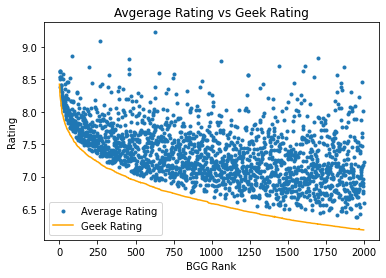

In [8]:
plt.scatter(bgg_ratings['rank'], bgg_ratings['avg_rating'], label='Average Rating', marker='.')
plt.plot(bgg_ratings['geek_rating'], label='Geek Rating', color='orange')
plt.legend()

plt.title('Avgerage Rating vs Geek Rating')
plt.xlabel('BGG Rank')
plt.ylabel('Rating');

In [9]:
# Find trendline for upcoming scatterplot
z = np.polyfit(bgg_ratings['rank'], bgg_ratings['rating_diff'], 1)
p = np.poly1d(z)

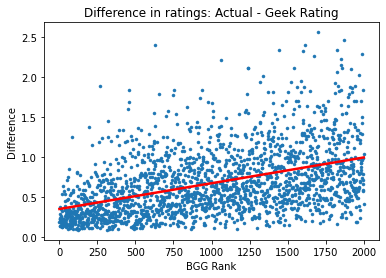

In [10]:
plt.scatter(bgg_ratings['rank'], bgg_ratings['rating_diff'], marker='.', lw=0.5)
plt.plot(bgg_ratings['rank'], p(bgg_ratings['rank'],), color='r', lw=2.5)

plt.title('Difference in ratings: Actual - Geek Rating')
plt.ylabel('Difference')
plt.xlabel('BGG Rank');

In [11]:
# Find average of difference between actual and geek rating
bgg_ratings['rating_diff'].mean()

0.6747473700000001

### Average Rating vs Geek Rating

It appears that Geek Rating is smoothed compared to the rank of the game on BoardGameGeek. Also, the further down the rankings, the difference between `avg_rating` and `geek_rating` tends to be a little higher. On average, the difference is 0.67 points higer for `avg_rating` than `geek_rating`.

I will chose `avg_rating` as my target metric. The main consideration is that the `geek_rating` is definitely manipulated in some way. There is the possibility that `avg_rating` has had some manipulation as well, but this isn't a guarantee. Since this dataset is only the 2000 top rated games, and since the game with the fewest votes has 673 votes, it is unlikely that there is any significant manipulation on the `avg_rating` values.

## Categorical datasets

In [12]:
# Load other datasets
mechs = pd.read_csv('./data/mechanisms_2023.csv')
themes = pd.read_csv('./data/themes_2023.csv')
subdoms = pd.read_csv('./data/subdomains_2023.csv')
reimps = pd.read_csv('./data/reimplementations_2023.csv')

### Mechanisms

In [13]:
mechs.head()

,game_id,Acting,Action Drafting,Action Points,Action Queue,Action Retrieval,Action Timer,Action/Event,Advantage Token,Alliances,...,Turn Order: Time Track,Variable Phase Order,Variable Player Powers,Variable Set-up,Victory Points as a Resource,Voting,Worker Placement,Worker Placement with Dice Workers,"Worker Placement, Different Worker Types",Zone of Control
0,224517,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,161936,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,174430,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,342942,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,233078,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,1,0,0,0,0


In [14]:
mechs_count = mechs.iloc[:,1:].sum().sort_values(ascending=False)
mechs_count

Hand Management           711
Dice Rolling              608
Variable Player Powers    578
Set Collection            443
Open Drafting             411
                         ... 
Induction                   1
Questions and Answers       1
Passed Action Token         1
Auction: English            1
Singing                     1
Length: 188, dtype: int64

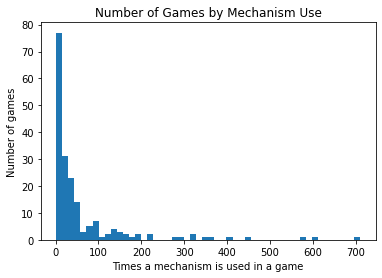

In [15]:
plt.hist(mechs_count, bins=50)

plt.title('Number of Games by Mechanism Use')
plt.xlabel('Times a mechanism is used in a game')
plt.ylabel('Number of games');

In [16]:
# Rename columns to distinguish what df the column comes in analysis
mechs = rename_columns(mechs, 'Mechanism')

### Theme

In [17]:
themes.head()

,Unnamed: 0,game_id,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,...,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,0,224517,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,161936,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,174430,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,342942,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,233078,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
# Drop `Unnamed: 0` column
themes = themes.drop('Unnamed: 0', axis=1).copy()

In [19]:
theme_count = themes.iloc[:,2:].sum().sort_values(ascending=False)
theme_count

Card Game                  541
Fantasy                    420
Economic                   323
Fighting                   272
Science Fiction            243
                          ... 
Expansion for Base-game      3
Music                        3
Vietnam War                  2
Korean War                   1
Game System                  1
Length: 82, dtype: int64

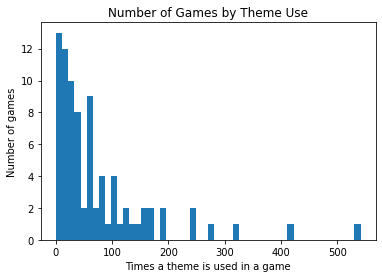

In [20]:
plt.hist(theme_count, bins=50)

plt.title('Number of Games by Theme Use')
plt.xlabel('Times a theme is used in a game')
plt.ylabel('Number of games');

In [21]:
# Rename columns to distinguish what df the column comes in analysis
themes = rename_columns(themes, 'Theme')

### Subdomains

In [22]:
subdoms.head()

,game_id,Abstract Games,Children's Games,Customizable Games,Family Games,Party Games,Strategy Games,Thematic Games,Wargames
0,224517,0,0,0,0,0,1,0,0
1,161936,0,0,0,0,0,1,1,0
2,174430,0,0,0,0,0,1,1,0
3,342942,0,0,0,0,0,1,0,0
4,233078,0,0,0,0,0,1,1,0


In [23]:
subdom_count = subdoms.iloc[:,1:].sum().sort_values(ascending=False)
subdom_count

Strategy Games        1004
Family Games           600
Thematic Games         401
Wargames               176
Party Games            125
Abstract Games         113
Customizable Games      70
Children's Games        40
dtype: int64

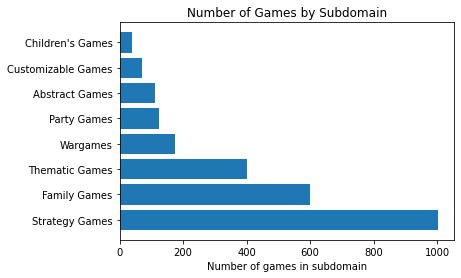

In [24]:
plt.barh(subdom_count.index, subdom_count)

plt.title('Number of Games by Subdomain')
plt.xlabel('Number of games in subdomain');

In [25]:
subdoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   game_id             2000 non-null   int64
 1   Abstract Games      2000 non-null   int64
 2   Children's Games    2000 non-null   int64
 3   Customizable Games  2000 non-null   int64
 4   Family Games        2000 non-null   int64
 5   Party Games         2000 non-null   int64
 6   Strategy Games      2000 non-null   int64
 7   Thematic Games      2000 non-null   int64
 8   Wargames            2000 non-null   int64
dtypes: int64(9)
memory usage: 140.7 KB


In [26]:
# Rename columns to distinguish what df the column comes in analysis
subdoms = rename_columns(subdoms, 'Subdomain')

### Re-implementations

In [27]:
reimps.head()

,game_id,parent_id,year,iteration,reimplementation,expansion,compilation
0,224517,28720,2018,2,1,0,0
1,161936,30549,2015,2,1,0,0
2,233078,12493,2017,2,1,0,0
3,115746,9609,2011,2,1,0,0
4,220308,120677,2017,2,1,0,0


In [28]:
reimps.shape

(470, 7)

In [29]:
reimps.iloc[:,3:].sum().sort_values(ascending=False)

iteration           1002
reimplementation     465
compilation            8
expansion              0
dtype: int64

### Initial Thoughts

- There are a number of mechanisms and themes that are used by a small amount of games
  - Mechanisms and themes used by too few games need dropped
  - Fewer than 5 games that use these mechanisms and themes feels right to drop
- Subdomains is a far broader set
  - These will make ideal slices to pinpoint features that are important to these subdomains that may be less predictive in other subdomains
- Re-implementations does not seem to have enough information to be relevant. It can be omitted from the model.

# Preprocessing

In [30]:
bgg_keep_cols = [
    'game_id',
    'name',
    'min_players',
    'max_players',
    'avg_time',
    'weight',
    'age',
    'avg_rating'
]

In [31]:
bgg_clean = bgg[bgg_keep_cols].copy()

In [32]:
bgg_clean.head()

,game_id,name,min_players,max_players,avg_time,weight,age,avg_rating
0,224517,Brass: Birmingham,2,4,120,3.8951,14,8.61254
1,161936,Pandemic Legacy: Season 1,2,4,60,2.8319,13,8.53513
2,174430,Gloomhaven,1,4,120,3.8964,14,8.62190
3,342942,Ark Nova,1,4,150,3.7253,14,8.53311
4,233078,Twilight Imperium: Fourth Edition,3,6,480,4.3077,14,8.61959


In [33]:
# Separated `name` from df so the game names are preserved, but not used in analysis
bgg_names_clean = bgg_clean[['game_id', 'name']]
bgg_clean = bgg_clean.drop('name', axis=1)

In [34]:
# Save `name` df for any future needs
bgg_names_clean.to_csv('./data/bgg_names.csv', index=False)

In [35]:
def drop_low_count_cols(df, threshold=5):
    """
    Returns df with columns that meet or exceed the threshold number of occurences
    """
    keep_cols = [df.columns[0]]
    for col in df.columns[1:]:
        if df[col].sum() >= threshold:
            keep_cols.append(col)
    return df[keep_cols].copy()

In [36]:
mechs_clean = drop_low_count_cols(mechs)

In [37]:
mechs_clean_count = mechs_clean.iloc[:,1:].sum().sort_values(ascending=False)
mechs_clean_count

Hand Management (Mechanism)           711
Dice Rolling (Mechanism)              608
Variable Player Powers (Mechanism)    578
Set Collection (Mechanism)            443
Open Drafting (Mechanism)             411
                                     ... 
Prisoner's Dilemma (Mechanism)          6
Speed Matching (Mechanism)              6
Turn Order: Random (Mechanism)          5
Closed Economy Auction (Mechanism)      5
Lose a Turn (Mechanism)                 5
Length: 168, dtype: int64

In [38]:
themes_clean = drop_low_count_cols(themes)

In [39]:
themes_clean_count = themes_clean.iloc[:,1:].sum().sort_values(ascending=False)
themes_clean_count

Card Game (Theme)               541
Fantasy (Theme)                 420
Economic (Theme)                323
Fighting (Theme)                272
Science Fiction (Theme)         243
                               ... 
American Civil War (Theme)        7
American Indian Wars (Theme)      7
Electronic (Theme)                7
Math (Theme)                      6
Mature / Adult (Theme)            6
Length: 77, dtype: int64

In [40]:
df_final = pd.merge(bgg_clean, mechs_clean, on='game_id', how='outer')
df_final = pd.merge(df_final, themes_clean, on='game_id', how='outer')
df_final = pd.merge(df_final, subdoms, on='game_id', how='outer')

In [41]:
# Set `game_id` to df index
df_final = df_final.set_index('game_id')
df_final.head()

,min_players,max_players,avg_time,weight,age,avg_rating,Acting (Mechanism),Action Drafting (Mechanism),Action Points (Mechanism),Action Queue (Mechanism),...,World War II (Theme),Zombies (Theme),Abstract Games (Subdomain),Children's Games (Subdomain),Customizable Games (Subdomain),Family Games (Subdomain),Party Games (Subdomain),Strategy Games (Subdomain),Thematic Games (Subdomain),Wargames (Subdomain)
game_id,,,,,,,,,,,,,,,,,,,,,
224517,2,4,120,3.8951,14,8.61254,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161936,2,4,60,2.8319,13,8.53513,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
174430,1,4,120,3.8964,14,8.62190,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
342942,1,4,150,3.7253,14,8.53311,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
233078,3,6,480,4.3077,14,8.61959,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


### Standardize non-binary columns

In [42]:
stand_cols = [
    'min_players',
    'max_players',
    'avg_time',
    'weight',
    'age'
]

In [43]:
# Standardize non-binary columns in df
ct = ColumnTransformer(
    [('scale', StandardScaler(), stand_cols)],
    remainder='passthrough'
)

scaled = ct.fit_transform(df_final)

In [44]:
df_final = pd.DataFrame(scaled, columns=df_final.columns, index= df_final.index)

In [45]:
df_final.head()

,min_players,max_players,avg_time,weight,age,avg_rating,Acting (Mechanism),Action Drafting (Mechanism),Action Points (Mechanism),Action Queue (Mechanism),...,World War II (Theme),Zombies (Theme),Abstract Games (Subdomain),Children's Games (Subdomain),Customizable Games (Subdomain),Family Games (Subdomain),Party Games (Subdomain),Strategy Games (Subdomain),Thematic Games (Subdomain),Wargames (Subdomain)
game_id,,,,,,,,,,,,,,,,,,,,,
224517,0.242033,-0.158856,0.066285,1.693303,1.112987,8.61254,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
161936,0.242033,-0.158856,-0.122763,0.382666,0.707232,8.53513,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
174430,-1.169237,-0.158856,0.066285,1.694906,1.112987,8.62190,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
342942,-1.169237,-0.158856,0.160809,1.483986,1.112987,8.53311,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
233078,1.653303,0.146343,1.200576,2.201927,1.112987,8.61959,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [46]:
df_final.to_csv('./data/bgg_processed.csv')